<a href="https://colab.research.google.com/github/Nidhi-S-Vas/Assignment-case_studies/blob/main/Casestudy06_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Objective: Classify tweets about tech products as positive or negative. Evaluation metric: accuracy.

#Environment Setup

In [65]:

import os, re
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# NLTK downloads (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#Load Dataset

In [66]:
df = pd.read_csv("/content/tweets.csv")
df.head()
df.info()
print(df.columns)
print(df['label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7920 non-null   int64 
 1   label   7920 non-null   int64 
 2   tweet   7920 non-null   object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB
Index(['id', 'label', 'tweet'], dtype='object')
label
0    5894
1    2026
Name: count, dtype: int64


#Exploratory Data Analysis (EDA)

,tweet,label
4896,Photo: cause we both dressed up today  #boyfr...,0
7539,"@skullcandy your product is brutal, 1 headphon...",1
1677,Sunset Today in Zeeland ;-) Samsung Mobile S4 ...,0
1964,God $&@*# it playstation share feature!! Cutti...,0
3025,Awe he's da bestest :) #boyfriend him #iloveyo...,0
6260,Sunset One Minute Ago ;-) #europe #zeeland #sa...,0
6306,10Pcs Exquisite Squishy Random Charm in http:/...,0
2436,I literally got the iPhone 6 YESTERDAY and it ...,1


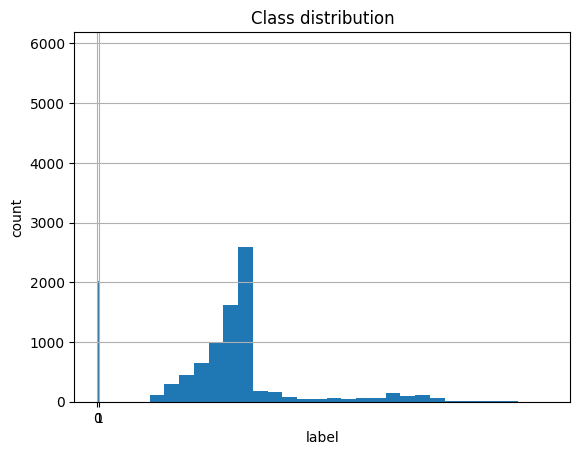

In [67]:
sns.countplot(x='label', data=df); plt.title('Class distribution')
df['tweet_length'] = df['tweet'].astype(str).apply(len)
df['tweet_length'].hist(bins=30)
df[['tweet','label']].sample(8, random_state=42)


In [68]:
# Check for duplicate rows in the dataset
print(f"Number of duplicate rows: {df.duplicated().sum()}")  # Duplicates can affect model performance


Number of duplicate rows: 0


In [69]:
# Check for any missing or null values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())  # Null values can affect preprocessing and model training



Missing Values in Each Column:
id              0
label           0
tweet           0
tweet_length    0
dtype: int64


#Text Preprocessing & Cleaning

In [70]:
from nltk import pos_tag
# Initialize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# POS tagging helper
def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

# Cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # URLs
    text = re.sub(r'@\w+', '', text)  # mentions
    text = re.sub(r'#', '', text)  # remove hashtag symbol
    text = re.sub(r'[^a-z\s]', '', text)  # keep letters only
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tagged = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(w, get_wordnet_pos(p)) for w, p in tagged]
    return " ".join(lemmatized)

# Apply cleaning
df['clean_tweet'] = df['tweet'].apply(clean_text)
df[['tweet', 'clean_tweet', 'label']].head()


,tweet,clean_tweet,label
0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...,0
1,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...,0
2,We love this! Would you go? #talk #makememorie...,love would go talk makememories unplug relax i...,0
3,I'm wired I know I'm George I was made that wa...,im wire know im george make way iphone cute da...,0
4,What amazing service! Apple won't even talk to...,amazing service apple wont even talk question ...,1


#Feature Extraction (TF-IDF)

In [71]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_tweet'])
y = df['label']

print("Feature matrix shape:", X.shape)
print("Sparsity: {:.2f}%".format(100 * X.nnz / (X.shape[0]*X.shape[1])))
print(y.shape)

Feature matrix shape: (7920, 20000)
Sparsity: 0.07%
(7920,)


#Train/Test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (6336, 20000)
Test size: (1584, 20000)


#Model Training (Multiple Models)

In [73]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Linear SVM": LinearSVC(max_iter=5000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Naive Bayes": MultinomialNB()
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    # Print results
    print(f"\n📊 {name}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print("\nClassification Report (Test Data):")
    print(classification_report(y_test, y_pred_test))
    print("-"*70)

    # Save results
    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc
    })

# Create DataFrame with results
results_df = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)

# Display final comparison table
print("\n✅ Final Model Comparison:")
results_df


🔹 Training Logistic Regression...

📊 Logistic Regression
Train Accuracy: 0.9227
Test Accuracy:  0.8750

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1179
           1       0.84      0.63      0.72       405

    accuracy                           0.88      1584
   macro avg       0.86      0.79      0.82      1584
weighted avg       0.87      0.88      0.87      1584

----------------------------------------------------------------------
🔹 Training Linear SVM...

📊 Linear SVM
Train Accuracy: 0.9962
Test Accuracy:  0.8870

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1179
           1       0.80      0.74      0.77       405

    accuracy                           0.89      1584
   macro avg       0.86      0.84      0.85      1584
weighted avg       0.88      0.89      0.89      1584

---------------

,Model,Train Accuracy,Test Accuracy
0,Linear SVM,0.996212,0.886995
1,Logistic Regression,0.922664,0.875000
2,Naive Bayes,0.929135,0.871212
3,Random Forest,0.999684,0.864899


#Model Comparison and Evaluation

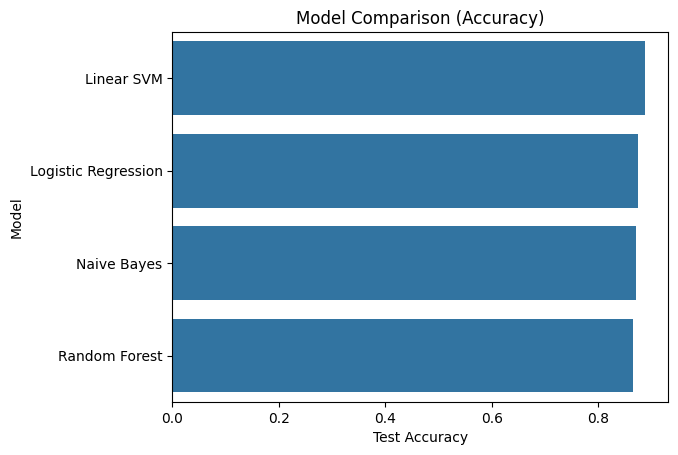

Best model is: Linear SVM


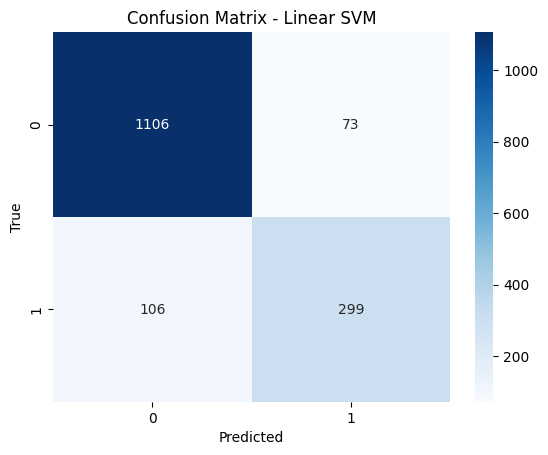

In [74]:
sns.barplot(x='Test Accuracy', y='Model', data=results_df)
plt.title('Model Comparison (Accuracy)')
plt.show()

best_model_name = results_df.iloc[0]['Model']
print(f"Best model is: {best_model_name}")

best_model = models[best_model_name]
y_best_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Among all models tested, the Linear SVM achieved the highest test accuracy, indicating better generalization on unseen data. Since SVMs handle high-dimensional and sparse text features effectively, it was selected as the final model for sentiment classification. Although Logistic Regression performed closely, SVM showed slightly better performance and robustness.

#Train Final Model on Entire Dataset

In [75]:
# Select the best performing model based on your results
best_model_name = "Linear SVM"   # update this if your best model is different
best_model = models[best_model_name]

# Train the best model on the entire dataset (X, y)
# This lets the model learn from all available data for future predictions
final_model = best_model.fit(X, y)

print(f"Final model '{best_model_name}' trained on the full dataset!")


Final model 'Linear SVM' trained on the full dataset!


#  Define Sentiment Prediction Function

In [76]:
def predict_sentiment(tweet, model=final_model, vectorizer=tfidf):
    """
    Predict the sentiment of a given tweet using a trained LinearSVC model.
    Returns sentiment, confidence (based on decision function), and decision scores.
    """

    # 1. Clean and preprocess the input tweet
    processed = clean_text(tweet)

    # 2. Transform the cleaned text using the trained TF-IDF vectorizer
    vec = vectorizer.transform([processed])

    # 3. Predict the class (0 = positive, 1 = negative)
    pred = model.predict(vec)[0]

    # 4. Use decision_function to estimate confidence
    # (LinearSVC does not have predict_proba)
    if hasattr(model, "decision_function"):
        decision = model.decision_function(vec)[0]

        # Convert decision value into a pseudo-confidence score (0 to 1)
        # Large positive value → strong Positive, large negative → strong Negative
        confidence = 1 / (1 + np.exp(-abs(decision)))  # Sigmoid scaling

        # We can treat the scaled score as "probability-like"
        positive_prob = 1 / (1 + np.exp(-decision))
        negative_prob = 1 - positive_prob
    else:
        decision = None
        confidence = None
        positive_prob = None
        negative_prob = None

    # 5. Map predicted label to sentiment
    sentiment = "Positive" if pred == 0 else "Negative"

    return {
        'tweet': tweet,
        'sentiment': sentiment,
        'confidence': confidence,
        'positive_prob': positive_prob,
        'negative_prob': negative_prob
    }


#Test Example Predictions

In [77]:
sample_tweets = [
    "Absolutely love the new camera features, pictures look amazing!",   # Positive
    "This phone keeps freezing, very disappointed with the update.",    # Negative
    "Customer support was fast and helpful, really satisfied.",         # Positive
    "The battery drains too quickly, not good at all.",                 # Negative
    "Loving the smooth performance and sleek design of my new laptop!", # Positive
    "The app keeps crashing every time I open it, terrible experience.",# Negative
]

print("\n" + "="*60)
print("SAMPLE SENTIMENT PREDICTIONS")
print("="*60)

for t in sample_tweets:
    res = predict_sentiment(t)
    print(f"\nTweet: {t}")
    print(f"Predicted Sentiment: {res['sentiment']}")
    print(f"Confidence: {res['confidence']:.3f}")
    print(f"Positive Score: {res['positive_prob']:.3f}, Negative Score: {res['negative_prob']:.3f}")


SAMPLE SENTIMENT PREDICTIONS

Tweet: Absolutely love the new camera features, pictures look amazing!
Predicted Sentiment: Positive
Confidence: 0.803
Positive Score: 0.197, Negative Score: 0.803

Tweet: This phone keeps freezing, very disappointed with the update.
Predicted Sentiment: Negative
Confidence: 0.598
Positive Score: 0.598, Negative Score: 0.402

Tweet: Customer support was fast and helpful, really satisfied.
Predicted Sentiment: Positive
Confidence: 0.691
Positive Score: 0.309, Negative Score: 0.691

Tweet: The battery drains too quickly, not good at all.
Predicted Sentiment: Positive
Confidence: 0.597
Positive Score: 0.403, Negative Score: 0.597

Tweet: Loving the smooth performance and sleek design of my new laptop!
Predicted Sentiment: Positive
Confidence: 0.742
Positive Score: 0.258, Negative Score: 0.742

Tweet: The app keeps crashing every time I open it, terrible experience.
Predicted Sentiment: Negative
Confidence: 0.618
Positive Score: 0.618, Negative Score: 0.382


#Pickling the mode

In [78]:
import pickle

# Save the trained model
with open("final_sentiment_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

print("\nModel and vectorizer saved successfully!")



Model and vectorizer saved successfully!
